In [1]:
# Environment details
# env_name        = "Measurement Regret Environment (c=0.1)"
# fileName_env    = "Loss_01"
# has_ideal_line  = True
# ideal_value     = 0.875

# env_name        = "Measurement Regret Environment (c=0.2)"
# fileName_env    = "Loss_02"
# has_ideal_line  = True
# ideal_value     = 0.8

env_name        = "Measurement Regret Environment (c=0.05)"
fileName_env    = "Loss_005"
has_ideal_line  = True
ideal_value     = 0.938

# env_name        = "4x4 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_standard4_semi-slippery"
# has_ideal_line  = False

# env_name        = "4x4 Frozen Lake Environment (slippery)"
# fileName_env    = "Lake_standard4_slippery"
# has_ideal_line  = False

# env_name        = "4x4 Frozen Lake Environment (deterministic)"
# fileName_env    = "Lake_standard4_det"
# has_ideal_line  = False

# env_name        = "8x8 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_standard8_semi-slippery"
# has_ideal_line  = False

# env_name        = "12x12 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_random12_semi-slippery"
# has_ideal_line  = False

# env_name        = "16x16 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_random16_semi-slippery"
# has_ideal_line  = False

# env_name        = "20x20 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_random20_semi-slippery"
# has_ideal_line  = False


# Algorithm details
fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "ACNO_OTP", "AMRL"]
legend_alg      = ["BAM-QMDP", "DBAM-QMDP", "ACNO-OTP", "AMRL-Q"]

# fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL"]
# legend_alg      = ["BAM-QMDP",  "DBAM-QMDP", "AMRL-Q", ]

import numpy as np
# Plotting variables
max_eps         = np.inf       # Overrides x-axis if too big (put 1_000_000 to not use)
interval        = 0.67      # Determines confidence interval
w1, w2          = 25,1      # Determine smooting window and order

# Filename details (should stay constant!)
Data_path       = "Data/Run2/"
fileName_begin  = "AMData"
fileName_end    = ".json"

In [2]:
# creating names:
Files_to_read = []
nmbr_files = len(fileName_alg)

for i in range(nmbr_files):
    Files_to_read.append("{}_{}_{}{}".format(fileName_begin,fileName_alg[i],fileName_env,fileName_end))
    
nmbr_files      = len(Files_to_read)

# Imports
import json
import math as m
import matplotlib.pyplot as plt
import datetime
from scipy.signal import savgol_filter
import scipy.stats as sts
import warnings
import seaborn as sns
timestamp = datetime.datetime.now().strftime("%d%m%Y%H%M%S")

# Plot Naming

Plot_names_title    = ["Average return", "Average steps", "Average measurements", "Average cumulative reward"]
Plot_Y_Label        = ["Return per Episode", "Steps", "Measurements", "Reward (Cumulative)"]
Plot_names_file     = ["Reward", "Steps", "Measures", "cumReward"]

nmbr_plots          = len(Plot_names_title)

In [3]:
# Data to obtain:

nmbr_steps      = []
measure_cost    = []

avg_reward,std_reward, min_reward, max_reward = [], [], [], []
avg_cum_reward      = []

avg_steps, std_steps, min_steps, max_steps = [], [], [], []
avg_measures, std_measures, min_measures, max_measures = [], [], [], []
avg_reward_noCost   = []

nmbr_eps = []
nmbr_runs = []
measure_cost = []
# Read data:

for file_name in Files_to_read:
    with open(Data_path + file_name) as file:
        contentDict = json.load(file)
        
        avg_reward.append       (savgol_filter( np.average  (contentDict["reward_per_eps"]      , axis=0), w1, w2 ))
        std_reward.append       ( np.std ( savgol_filter(contentDict["reward_per_eps"], w1, w2 ) , axis=0)) 

        avg_steps.append        (savgol_filter(np.average (contentDict["steps_per_eps"]       , axis=0), w1, w2 ) )
        std_steps.append       ( np.std ( savgol_filter(contentDict["steps_per_eps"], w1, w2 ) , axis=0)) 
        avg_measures.append     (savgol_filter(np.average (contentDict["measurements_per_eps"], axis=0), w1, w2 ) )
        std_measures.append       ( np.std ( savgol_filter(contentDict["measurements_per_eps"], w1, w2 ) , axis=0)) 

        nmbr_eps.append     (int(contentDict["parameters"]["nmbr_eps"]))
        nmbr_runs.append    (int(contentDict["parameters"]["nmbr_runs"]))
        measure_cost.append (float(contentDict["parameters"]["m_cost"]))


for i in range(nmbr_files):
    avg_cum_reward.append (np.cumsum(avg_reward[i]))
    
    rmin, rmax = sts.norm.interval(interval, loc=avg_reward[i], scale=std_reward[i])
    min_reward.append(rmin)
    max_reward.append(rmax)
    
    smin, smax = sts.norm.interval(interval, loc=avg_steps[i], scale=std_steps[i])
    min_steps.append(smin)
    max_steps.append(smax)
    
    mmin, mmax = sts.norm.interval(interval, loc=avg_measures[i], scale=std_measures[i])
    min_measures.append(mmin)
    max_measures.append(mmax)


all_data = [(avg_reward, min_reward, max_reward), (avg_steps,min_steps,max_steps),
            (avg_measures,min_measures, max_measures), (avg_cum_reward, avg_cum_reward, avg_cum_reward)]
eps_to_plot = min(np.min(nmbr_eps), max_eps)

c:\Users\merli\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\merli\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [4]:
file_text = """
Data collected from running in {} , using the following algorithms:
""".format(env_name)

for i in range(nmbr_files):
    this_rew, this_steps, this_measures= np.average(avg_reward[i]), np.average(avg_steps[i]),np.average(avg_measures[i])
    std_rew, std_steps, std_measures = np.std(avg_reward[i]), np.std(avg_steps[i]),np.std(avg_measures[i])

    toi = np.size(avg_reward[i])
    fromi = m.ceil(toi*0.9)
    last_rew, last_steps, last_measures = np.average(avg_reward[i][fromi:toi]), np.average(avg_steps[i][fromi:toi]),np.average(avg_measures[i][fromi:toi])
    last_std_rew, last_std_steps, last_std_measures = np.std(avg_reward[i][fromi:toi]), np.std(avg_steps[i][fromi:toi]),np.std(avg_measures[i][fromi:toi])
    


    file_text +="""
{}:
nmbr_eps                    = {}
nmbr_runs                   = {}
measure_cost                = {}

avererage reward            = {}            (with std = {})
average nmbr steps          = {}            (with std = {})
average nmbr measurements   = {}            (with std = {})

In last 1/10th of episodes:
avererage reward            = {}            (with std = {})
average nmbr steps          = {}            (with std = {})
average nmbr measurements   = {}            (with std = {})

""".format(
        fileName_alg[i],
        nmbr_eps[i], nmbr_runs[i], measure_cost[i],
        this_rew, std_rew, this_steps, std_steps, this_measures, std_measures,
        last_rew, last_std_rew, last_steps, last_std_steps, last_measures, last_std_measures
    )

data_file_name = Data_path+"/Compiled/Data_{}".format(fileName_env)
with open(data_file_name, 'w') as f:
    f.write(file_text)

In [5]:

plt.style.use("ggplot")
#plt.style.use("bmh")

for i in range (nmbr_plots):

    #plt.title("{} in {}".format(Plot_names_title[i], env_name))
    plt.ylabel(Plot_Y_Label[i])
    plt.xlabel("Episode")
    
    x = np.arange(eps_to_plot)
    
    if has_ideal_line and i==0:
        plt.plot(x, np.repeat(ideal_value,eps_to_plot), 'k--', label="optimal value")
    
    for j in range(nmbr_files):
        plt.plot(x,all_data[i][0][j][:eps_to_plot], label=legend_alg[j])
        plt.fill_between(x, all_data[i][1][j][:eps_to_plot], all_data[i][2][j][:eps_to_plot], alpha=0.1)

    
    plt.legend()
    plt.savefig(Data_path+"Plots/Plot_{}_{}".format(fileName_env, Plot_names_file[i]))
    if False:
        plt.show()
    
    plt.clf()


<Figure size 640x480 with 0 Axes>

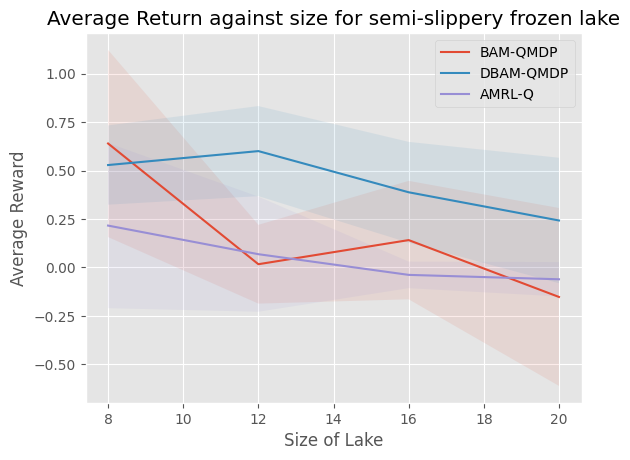

In [19]:

if True:
    

    fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL"]
    legend_alg      = ["BAM-QMDP",  "DBAM-QMDP", "AMRL-Q", ]
    nmbr_algs       = len(fileName_alg)

    sizes = [8,12,16,20]
    nmbr_files = len(sizes)
    avg_rewards, avg_measures, std_rewards, std_measures = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))
    rewardsmin, rewardsmax = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))

    check_percentage = 0.9


    # Collect all data
    for (algnmbr, algName) in enumerate(fileName_alg):
        for i in range(nmbr_files):
            filename = "AMData_{}_Lake_random{}_semi-slippery.json".format(fileName_alg[algnmbr],  str(sizes[i]))
            
            with open(Data_path + filename) as file:
                contentDict = json.load(file)
                
                nmbr_eps = int(contentDict["parameters"]["nmbr_eps"])
                toi = nmbr_eps
                fromi = m.ceil(toi*check_percentage)
                
                rewards = np.array(contentDict["reward_per_eps"])[:,fromi:toi]
                avg_rewards[algnmbr,i]  = np.average( rewards )
                std_rewards[algnmbr,i]  = np.std( rewards )
                rewardsmin[algnmbr,i], rewardsmax[algnmbr,i] = sts.norm.interval(interval, loc=avg_rewards[algnmbr,i], scale=std_rewards[algnmbr,i])
                
                avg_measures[algnmbr,i] = np.average(   np.average(contentDict["measurements_per_eps"], axis=0)[fromi:toi]  )
                std_measures[algnmbr,i] = np.std(       np.std(contentDict["measurements_per_eps"], axis=0)[fromi:toi]      )
            

        plt.plot(sizes, avg_rewards[algnmbr], label = legend_alg[algnmbr])
        plt.fill_between(sizes, rewardsmin[algnmbr], rewardsmax[algnmbr], alpha=0.1)

    plt.title("Average Return against size for semi-slippery frozen lake")
    plt.ylabel("Average Reward")
    plt.xlabel("Size of Lake")
    plt.legend()
    plt.show()

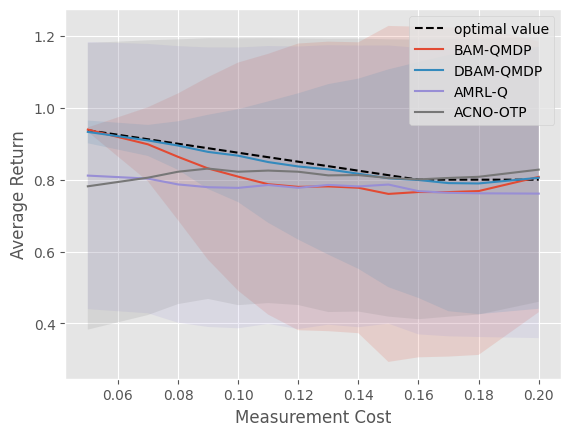

In [20]:
if True:

    fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL", "ACNO_OTP"]
    legend_alg      = ["BAM-QMDP",  "DBAM-QMDP", "AMRL-Q","ACNO-OTP" ]
    nmbr_algs       = len(fileName_alg)
    
    this_window, this_order = 5, 1

    costs = np.linspace(start=0.05, stop=0.2, num=16)
    costs_names = ["005","006", "007", "008", "009", "01", "011", "012", "013", "014", "015", "016", "017", "018", "019", "02"]
    nmbr_files = len(costs)
    avg_rewards, avg_measures, std_rewards, std_measures = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))
    rewardsmin, rewardsmax = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))

    check_percentage = 0.9
    nmbr_points = 200
    costs_extended = np.linspace(np.min(costs), np.max(costs), nmbr_points)
    optimal_line = (0.8-costs_extended) / 0.8
    optimal_line[optimal_line < 0.8] = 0.8
    plt.plot(costs_extended, optimal_line, 'k--', label="optimal value")


    # Collect all data
    for (algnmbr, algName) in enumerate(fileName_alg):
        for i in range(nmbr_files):
            filename = "AMData_{}_Loss_{}.json".format(fileName_alg[algnmbr],  str(costs_names[i]))
            
            with open(Data_path + filename) as file:
                contentDict = json.load(file)
                
                nmbr_eps = int(contentDict["parameters"]["nmbr_eps"])
                toi = nmbr_eps
                fromi = m.ceil(toi*check_percentage)
                
                rewards = np.array(contentDict["reward_per_eps"])[:,fromi:toi]
                avg_rewards[algnmbr,i]  = np.average( rewards )
                std_rewards[algnmbr,i]  = np.std( rewards )
                rewardsmin[algnmbr,i], rewardsmax[algnmbr,i] = sts.norm.interval(interval, loc=avg_rewards[algnmbr,i], scale=std_rewards[algnmbr,i])
            
        avg_rewards = savgol_filter( avg_rewards, this_window, this_order)
        std_rewards = savgol_filter( std_rewards, this_window, this_order)
        # rewardsmin[algnmbr], rewardsmax[algnmbr] = sts.norm.interval(interval, loc=avg_rewards[algnmbr], scale=std_rewards[algnmbr])
        
        plt.plot(costs, avg_rewards[algnmbr], label = legend_alg[algnmbr])
        plt.fill_between(costs, rewardsmin[algnmbr], rewardsmax[algnmbr], alpha=0.15)

    #plt.title("Average Return against measuring cost")
    plt.ylabel("Average Return")
    plt.xlabel("Measurement Cost")
    plt.legend()
    plt.show()